In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import random


from numpy import random
from sklearn.preprocessing import OrdinalEncoder
from IPython import display


tf.compat.v1.disable_eager_execution()

#%matplotlib inline
random.seed(246)

In [ ]:
df_train = pd.read_csv("smaller_train.csv")
df_test = pd.read_csv("smaller_test.csv")
df_valid = pd.read_csv("/content/drive/MyDrive/privateSammlung/smaller_valid.csv")

df_train['s'] = 1
df_test['s'] = 2
df_valid['s'] = 2

df = pd.concat([df_train, df_test, df_valid], ignore_index=True)

In [ ]:
#df.describe()
#df = df[df['journey_id'].isin(range(120000, 140000))]   only temporary to have less data, this interval, because it contains transaction == 1
df[df['transaction']==1]  # as one can see here

,transaction,platform,country_name,journey_id,channel_id,timestamp,timestamp_conversion,s
525,1,desktop,South Korea,130944,2,4236.409495,4239.122778,1
526,1,mobileWeb,Indonesia,130978,3,4302.195794,6452.081111,1
527,1,mobileWeb,United States,130990,3,2941.232592,2947.790278,1
528,1,mobileWeb,Germany,131006,6,2673.734090,2891.494722,1
529,1,mobileWeb,France,131046,6,4990.108078,4990.150000,1
...,...,...,...,...,...,...,...,...
22287,1,mobileWeb,Mexico,130976,1,3838.207627,5125.785278,2
22288,1,mobileWeb,Australia,130952,1,5050.358723,5171.806111,2
22289,1,android,Mexico,130976,11,5111.299453,5125.785278,2
22290,1,mobileWeb,Spain,130976,8,5031.411836,5125.785278,2


## Transform the transaction column s.t. only  last tp before conversioin has transaction == 1

In [ ]:
df['time_diff'] = df['timestamp_conversion'] - df['timestamp'] #create new var for timedifference

In [ ]:
df[df['time_diff'] < 0] #All observations where there's a touchpoint after conversion... 34 rows will be ignored

,transaction,platform,country_name,journey_id,channel_id,timestamp,timestamp_conversion,s,time_diff
10138,1,android,Poland,137811,11,4029.156188,4029.151944,1,-0.004243


In [ ]:
df.drop(df[df.time_diff < 0].index, inplace = True) #remove these time_diff < 0 i.e. tp after transaction

In [ ]:
df = df.sort_values('timestamp')
df = df.sort_values('journey_id')

In [ ]:
# This transform df so that only last touchpoint before conversion gets transaction = 1. Because this leaves to few
# observations with transaction == 1 we don't consider it for now

groups = df.groupby('journey_id').time_diff
min_val = groups.transform(min) #search minimal time_diff in each group <=> closest tp to conversion

cond1 = df.time_diff==min_val #define condition when transaction should be 1

df['transaction'] = np.select([cond1], [1], default = 0) #transform transaction


## Long Journeys

In [ ]:
journ_len = df.groupby("journey_id")["s"].count()
print(journ_len.describe())
p1 = 0.99
p2 = 0.9999
print('The ', p1*100, '% quantile is ', np.quantile(journ_len, p1))
print('The ', p2*100, '% quantile is ', np.quantile(journ_len, p2))

count    2035.000000
mean       10.953808
std        18.527553
min         1.000000
25%         2.000000
50%         4.000000
75%        11.000000
max       100.000000
Name: s, dtype: float64
The  99.0 % quantile is  98.0
The  99.99 % quantile is  100.0


In [ ]:
max_journ_len = 16
df = df.groupby('journey_id').filter(lambda x: len(x) <= max_journ_len)

## How to handle object variables

###  Dummy variables for country, platform and channel, better but also huge data

In [ ]:
df = pd.get_dummies(df, columns = ['channel_id'], prefix = 'channel', prefix_sep = '_', dtype = float)
df = pd.get_dummies(df, columns = ['country_name'], prefix = 'country', prefix_sep = '_', dtype = float)
df = pd.get_dummies(df, columns = ['platform'], prefix = 'platform', prefix_sep = '_', dtype = float)

### Ordinal Encoder, not really accurate, but doesn't blow up df

In [ ]:
#ordinal_encoder = OrdinalEncoder()
#for column in df.columns:
#    if df[column].dtypes == 'object':
#        df[column] = ordinal_encoder.fit_transform(df[[column]])

## Split train / test

In [ ]:
df_train = df[df['s'] == 1]
df_test = df[df['s'] == 2]

## Remove irrelevant columns

In [ ]:
df_train = df_train.drop(['s', 'timestamp_conversion', 'time_diff'], axis = 1) #cant be used for prediction
df_test = df_test.drop(['s', 'timestamp_conversion', 'time_diff'], axis = 1) #cant be used for prediction
#df_valid = df_valid.drop(['s', 'timestamp_conversion', 'time_diff'], axis = 1) #cant be used for prediction

Next step: transform to tensor

In [ ]:
batch_size=800

In [ ]:
def mta2tensor(df, max_journ_len):
    colx = df.shape[1] - 1
    df_transaction = df['transaction']
    data = df.drop('transaction', axis=1)
    grous = df.groupby('journey_id')
    x = []
    y = []
    cj_count = 1
    for i in df['journey_id'].unique():
        if  cj_count < batch_size:
            x1 = grous.get_group(i)

            x1 = x1.drop(['journey_id'], axis=1)
            x1 = x1.values.tolist()

            y_prop = df_transaction.loc[grous.get_group(i).index]
            y_prop = y_prop.values.tolist()

            y1 = []
            for l in range(len(y_prop)):
                y1.append([y_prop[l]])

            for j in range(max_journ_len - len(x1)):

                x1.append([0] * colx)  # 52 is number of columns without journey_id an transaction
                y1.append([0])

            x.append(x1)
            y.append(y1)
            cj_count = cj_count + 1
        else: break

    return x, y
    #tf.convert_to_tensor(x), tf.convert_to_tensor(y)


In [ ]:
X_test, Y_test = mta2tensor(df_train, max_journ_len)
X_train, Y_train = mta2tensor(df_test, max_journ_len)
#X_valid, Y_valid = mta2tensor(df_valid, max_journ_len)

In [ ]:
len(X_test)

799

In [ ]:
input_dimensions = df_train.shape[1] - 1
batch_size = len(X_train)
time_size = max_journ_len
# what are good weights??
w_pos =  1
w_neg = 50
print(input_dimensions, batch_size, time_size)

119 799 16


In [ ]:
import tensorflow as tf

class GRU:
    """Implementation of a Gated Recurrent Unit (GRU) as described in [1].

    [1] Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555.  [Titel anhand dieser ArXiv-ID in Citavi-Projekt übernehmen]

    Arguments
    ---------
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
    """

    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size

        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Wr = tf.Variable(tf.random.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.1), name='Wr')
        self.Wz = tf.Variable(tf.random.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.1), name='Wz')
        self.Wh = tf.Variable(tf.random.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.1), name='Wh')

        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Ur = tf.Variable(tf.random.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.1), name='Ur')
        self.Uz = tf.Variable(tf.random.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.1), name='Uz')
        self.Uh = tf.Variable(tf.random.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.1), name='Uh')

        # Biases for hidden vectors of shape (hidden_size,)
        self.br = tf.Variable(tf.random.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.1), name='br')
        self.bz = tf.Variable(tf.random.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.1), name='bz')
        self.bh = tf.Variable(tf.random.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.1), name='bh')

        # Define the input layer placeholder
        self.input_layer = tf.compat.v1.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='input')

        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')

        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(input_dimensions, hidden_size)), name='h_0')

        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')

        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.

        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Definitions of z_t and r_t
        z_t = tf.sigmoid(tf.matmul(x_t, self.Wz) + tf.matmul(h_tm1, self.Uz) + self.bz)
        r_t = tf.sigmoid(tf.matmul(x_t, self.Wr) + tf.matmul(h_tm1, self.Ur) + self.br)

        # Definition of h~_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(tf.multiply(r_t, h_tm1), self.Uh) + self.bh)

        # Compute the next hidden state
        h_t = tf.multiply(1 - z_t, h_tm1) + tf.multiply(z_t, h_proposal)

        return h_t


In [ ]:

# The input dimensions correspond to the columns of the data set
# input_dimensions = 2 previously initialized

# Arbitrary number for the size of the hidden state
hidden_size = 32

# Initialize a session
session = tf.compat.v1.Session()

# Create a new instance of the GRU model
gru = GRU(input_dimensions, hidden_size)

# Add an additional layer on top of each of the hidden state outputs
W_output = tf.Variable(tf.random.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.1))
b_output = tf.Variable(tf.random.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.1))
output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, gru.h_t)

output = tf.clip_by_value(output, 1e-7, 1 - 1e-7) #necessary to be able to calculate log

# Create a placeholder for the expected output
expected_output = tf.compat.v1.placeholder(dtype=tf.float64, shape=(batch_size, time_size, 1), name='expected_output')

# Just use quadratic loss
#loss = tf.reduce_sum( tf.pow(output - expected_output, 2)) / float(batch_size)
# or Cross-entropy loss
loss = tf.reduce_mean(-(1.5 * expected_output * tf.math.log(output) + (1 - expected_output) * tf.math.log(1 - output)))

# Use the Adam optimizer for training
train_step = tf.compat.v1.train.AdamOptimizer(learning_rate=0.01).minimize(loss)


In [ ]:
# Initialize all the variables
init_variables = tf.compat.v1.global_variables_initializer()
session.run(init_variables)

# Initialize the losses
train_losses = []
validation_losses = []
ep = []
epochs = 1000

# Perform all the iterations
for epoch in range(epochs):
    # Compute the losses
    _, train_loss = session.run([train_step, loss], feed_dict={gru.input_layer: X_train, expected_output: Y_train})
    validation_loss = session.run(loss, feed_dict={gru.input_layer: X_test, expected_output: Y_test})

    # Log the losses
    train_losses += [train_loss]
    validation_losses += [validation_loss]

    # Display an update 10 times
    if epoch % (epochs/10) == 0:
        print('Iteration: %d, train loss: %.4f, test loss: %.4f' % (epoch, train_loss, validation_loss))

Iteration: 0, train loss: 0.0871, test loss: 0.5333
Iteration: 100, train loss: 0.4180, test loss: 0.5333
Iteration: 200, train loss: 0.4180, test loss: 0.5333
Iteration: 300, train loss: 0.4180, test loss: 0.5333
Iteration: 400, train loss: 0.4180, test loss: 0.5333
Iteration: 500, train loss: 0.4180, test loss: 0.5333
Iteration: 600, train loss: 0.4180, test loss: 0.5333
Iteration: 700, train loss: 0.4180, test loss: 0.5333
Iteration: 800, train loss: 0.4180, test loss: 0.5333
Iteration: 900, train loss: 0.4180, test loss: 0.5333


In [ ]:
losses= {  # 'epoch': ep,
        'train_losses': train_losses,
        'test_losses': validation_losses
        }
losses = pd.DataFrame(losses)
# losses['epoch']

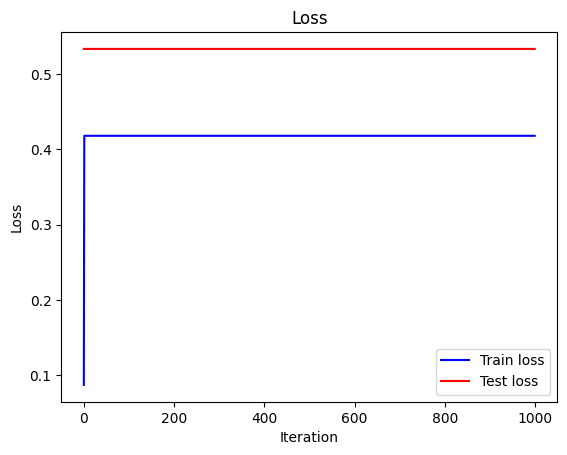

In [ ]:
plt.plot(train_losses, '-b', label='Train loss')
plt.plot(validation_losses, '-r', label='Test loss')
plt.legend(loc=0)
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

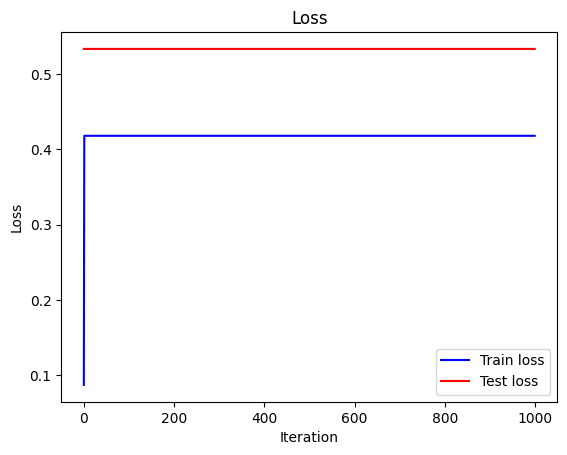

In [ ]:
plt.plot(train_losses, '-b', label='Train loss')
plt.plot(validation_losses, '-r', label='Test loss')
plt.legend(loc=0)
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()